In [3]:
import yt
yt.funcs.mylog.setLevel(40) # Surpresses YT status output.
import numpy as np
import matplotlib.pyplot as plt

In [155]:
file_path = './M4V02_rm7/turbsph_hdf5_plt_cnt_0109'

ds = yt.load(file_path) # loads in data into data set class. This is what we will use to plot field values
ad = ds.all_data() # Can call on the data set's property .all_data() to make an object 
                   # containing all data available to be parsed through.
                   # print ad['mass'] will print the list of all cell masses. print ad.mass().max()


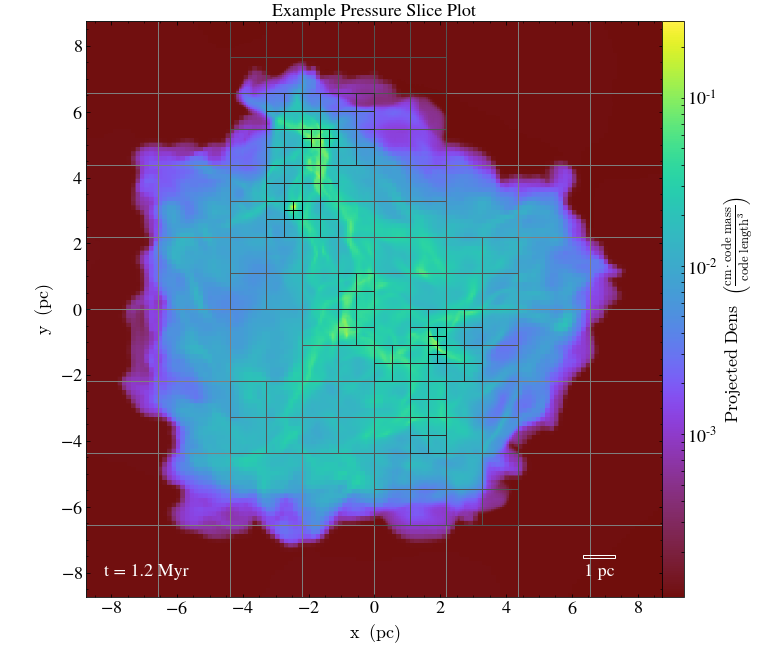

In [156]:
field ='dens'
ax = 'z'
plot_ = yt.ProjectionPlot(ds, ax, field)
plot_.annotate_timestamp()
plot_.annotate_grids()
#plot_.annotate_velocity()
#plot_.set_zlim('dens', 1.0e-3, 1.0e-1)
plot_.annotate_title('Example Pressure Slice Plot')
plot_.annotate_scale()
plot_.show()

In [157]:
for i, typ in enumerate(ad['particle_type']):
    if typ == 2.0:
        print ad['particle_posx'][i]#.to('pc').value

-7.5589632589e+18 code_length


How to find the mass of each cell within a sink?
* The easiest way to do this would be to have the data be written out to the `sinks_evol.dat` file but this may require a bit of work since I would have to transport data of looped over blocks within sink. An exercise worth doing,=.
* with yt plotting, I have the info of where the sink particle is as well as its radius. With this, I can create a spherical data object that reads the internal mass. The data-object can be set to the sink's position so it remains followed if plt files are looped over. Can I get sinktag data here?? Yeeea baby, with `ad['particle_tag']`. Oh shit, and `ad['particle_blk']` (same as `ad['particle_index']`) is available too.
* also have `ad['gas', 'sound_speed']`, `ad['gas', 'kT']`
`ad[mesh_id]` corresponds to the cell id that the particle is in??

https://yt-project.org/doc/analyzing/filtering.html

In [151]:
print ds.derived_field_list

[('all', 'mesh_id'), ('all', u'particle_accr_rate'), ('all', u'particle_accx'), ('all', u'particle_accy'), ('all', u'particle_accz'), ('all', 'particle_angular_momentum'), ('all', 'particle_angular_momentum_magnitude'), ('all', 'particle_angular_momentum_x'), ('all', 'particle_angular_momentum_y'), ('all', 'particle_angular_momentum_z'), ('all', u'particle_bgdy'), ('all', u'particle_blk'), ('all', u'particle_creation_time'), ('all', u'particle_csgm'), ('all', 'particle_cylindrical_velocity_theta'), ('all', 'particle_cylindrical_velocity_z'), ('all', u'particle_dmdt'), ('all', u'particle_dtold'), ('all', u'particle_eion'), ('all', u'particle_epep'), ('all', u'particle_gpot'), ('all', 'particle_index'), ('all', u'particle_kine'), ('all', 'particle_mass'), ('all', u'particle_nion'), ('all', u'particle_npep'), ('all', u'particle_oacx'), ('all', u'particle_oacy'), ('all', u'particle_oacz'), ('all', u'particle_old_pmass'), ('all', 'particle_ones'), ('all', 'particle_position'), ('all', 'part

In [152]:
print ad['particle_radius']
print ad['particle_thre']
print ad['gas', 'sound_speed'].to('km/s').value.max()


[  1.21895399e+19   1.30910111e+19] cm
[ 0.  0.] dimensionless
8.06129166006


In [163]:
center = ad['particle_position'][0].v

radius = (1.318344e17, 'cm')
ds2 = yt.load('./M4V02_rm7/turbsph_hdf5_plt_cnt_0108')

sph = ds2.sphere(center, radius)
#sp = ds.sphere([0.5, 0.5, 0.5], (1, 'kpc'))
print "The mean gas sound speed inside the sink is: ", (sph['gas','sound_speed']).mean()

cell_vol = sph['dx'].min().v ** 3
cell_masses = []
for den in sph['dens'].v:
    mass = den * cell_vol
    cell_masses.append(mass)
total_mass = sum(cell_masses) # in grams
G = 6.67e-8
virial_v = np.sqrt((3./5) * G * total_mass / radius[0])

print "maximum cell density is: ", sph['dens'].v.max()

print "Virial velocity of sink (km/s) is: ", virial_v*1e-5
print "Virial velocity is this nuber of times greater than gas soundspeed: ", virial_v*1e-5 / (sph['gas','sound_speed']).to("km/s").mean().v

The mean gas sound speed inside the sink is:  37300.2545902 cm/s
maximum cell density is:  2.53315170403e-18
Virial velocity of sink (km/s) is:  0.422466496592
Virial velocity is this nuber of times greater than gas soundspeed:  1.13261022273


In [160]:
#Energy budget of gas within sink
print sph['kinetic_energy'][0]
print sph['thermal_energy'][0]
print sph['total_energy'][0]
print (sph['thermal_energy'] / sph['total_energy']).mean()


6.27517970685e-10 dyne/cm**2
1252000384.0 erg/g
2979499264.0 erg/g
0.414487673614 dimensionless


In [121]:
#print sph['particle_tag']
#print("(x,  y,  z)                       Temperature(K)          cs(km/s)")
#print("-----------------------")
#for i in range(sph["temperature"].size):
#    print("(%f,  %f,  %f)    %f     %f" %
#          (sph["x"][i].to('pc'), 
#           sph["y"][i].to('pc'), 
#           sph["z"][i].to('pc'), 
#           sph["temperature"][i], 
#           sph["sound_speed"][i].v))
